# Importing Packages and API Setup

In [ ]:
# Only needs to be run upon first-time use
import sys
!{sys.executable} -m pip install alpha_vantage
!{sys.executable} -m pip install quandl

In [1]:
import numpy as np
import scipy.stats as stats
import itertools as it
import pandas as pd
import cmath as c
import matplotlib.pyplot as plt
import requests
from datetime import datetime as dt
import time
import quandl as q
# https://github.com/RomelTorres/alpha_vantage
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators 
from alpha_vantage.sectorperformance import SectorPerformances

In [2]:
#Alpha Vantage
API_URL = 'https://www.alphavantage.co/query?'
API_KEY1 = 'TMANNBF5NO707ZEI'
API_KEY2 = 'AO48IFCXLA3BX1O9'
API_KEY3 = 'GDJZQ31AX2TZRFA1'

# Quandl
q.ApiConfig.api_key = "ntUKZwApL5qnmU9pk_rB"

In [3]:
# Output formats: json dictionaries (default), DataFrame, csv.
# csv does not support ForeignExchange, SectorPerformances, TechIndicators.
# indexing_type can also be integer (default: date)
ts = TimeSeries(key=API_KEY1, output_format='pandas', indexing_type='date')
ti = TechIndicators(key=API_KEY1, output_format='pandas')
sp = SectorPerformances(key=API_KEY1, output_format='pandas')

In [4]:
tsd = [TimeSeries(key=API_KEY1, output_format='pandas', indexing_type='date'), 
       TimeSeries(key=API_KEY2, output_format='pandas', indexing_type='date'), 
       TimeSeries(key=API_KEY3, output_format='pandas', indexing_type='date')]

# Data Collection Methods

This is the primary method for retrieving data from the AlphaVantage API. Rather than worrying about all of the individual data collection methods, this method allows the user to just specify the key parameters, and the appropriate API method retrieves the data. Because the API only allows for 5 calls/minute, each block of ticker calls can be made one at a time every minute. Thus, **`collect()` is HIGHLY RECOMMENDED** as it prevents errors related to exceeding the 5 calls/minute rate.

In [5]:
global port # dictionary
global port_rets # dictionary

port = {} # Stores all stock data
port_rets = {} # Stores all return data

# Used to get individual stock data from the AlphaVantage API.
# symbols: list of stock tickers as strings
# start_date, end_date: string of date 'YYYY-MM-DD'
# intra_int: intraday interval; '1min', '5min', '15min', '30min', '60min' (default '15min')
# add: by default adds the searched asset to the portfolio.
def get_data(symbol, start_date= None, end_date= None, 
             int_type='daily_adjusted', intra_int='15min', add=True):
    if int_type is not 'daily_adjusted':
        data, meta = ts.get_intraday(symbol, interval=intra_int, 
                                     outputsize='full')
    else: 
        data, meta = ts.get_daily_adjusted(symbol, outputsize='full')

    # Remove numbers from column labels.
    data.rename(columns=lambda col: col[3:], inplace=True)

    # Filter the DataFrame to contain only those specified by the start and end dates.
    if start_date and end_date:
        data = data.loc[start_date:end_date]
    elif start_date:
        data = data.loc[start_date:]
    else:
        data = data.loc[:end_date]

    # Add the stock data to a DataFrame and reindex to be DateTime indices.
    df_stock = pd.DataFrame(data)
    df_stock.index = pd.to_datetime(df_stock.index)

    # By default, add to the portfolio
    if add:
        port[symbol] = df_stock

    return pd.DataFrame(df_stock)

In [6]:
# Used to calculate the daily percent change, log returns, and
# cumulative returns over time for each stock in the portfolio.
# portfolio: may refer to portfolio containing all stocks or an 
# individual stock
# symbol: specify ticker as string if calculating an individual 
# stock's returns not already in the portfolio
def calculate_returns(portfolio, symbol=None):

    # True if the portfolio is a dictionary containing multiple stocks.
    if type(portfolio) is type({1:2}):
        for symb, data in portfolio.items():

            # Get price close data.
            daily_close = data['close']

            # Calculate percent change for each period.
            daily_pct_change = daily_close.pct_change()
            daily_pct_change.fillna(0, inplace=True)

            # Calculate log returns for each period.
            daily_log_returns = np.log(daily_close.pct_change()+1)
            daily_log_returns.fillna(0, inplace=True)

            # Cumulative daily rate of return is useful to determine the 
            # value of an investment at regular intervals.
            cum_daily_return = (1 + daily_pct_change).cumprod()
            port_rets[symb] = pd.DataFrame({'pct change': daily_pct_change, 
                                       'log returns':daily_log_returns, 
                                       'cumulative daily':cum_daily_return})
        return port_rets[symb]

    # True if only calculating for one stock.
    else:
        daily_close = portfolio['close']
        daily_pct_change = daily_close.pct_change()
        daily_pct_change.fillna(0, inplace=True)

        daily_log_returns = np.log(daily_close.pct_change()+1)
        daily_log_returns.fillna(0, inplace=True)

        # Cumulative daily rate of return is useful to determine 
        # the value of an investment at regular intervals.
        cum_daily_return = (1 + daily_pct_change).cumprod()
        port_rets[symbol] = pd.DataFrame({'pct change': daily_pct_change, 
                                       'log returns':daily_log_returns, 
                                       'cumulative daily':cum_daily_return})
        return port_rets[symbol]

In [7]:
# Primary method for acquring stock data. Recommended over get_data() because
# it avoids the 5 API calls/min limitation by inherently waiting 1 minute if
# more than 5 stocks are being called at once.
# tickers: list of ticker strings
# start_date, end_date: string of date 'YYYY-MM-DD'
def collect(tickers, start=None, end=None):
    try: 
        grouped_ticks = [tickers[i*5:(i+1)*5] for i in range(
            (len(tickers)+ 4)// 5)]
        if len(grouped_ticks) > 1:
            for group in grouped_ticks:
                sub_collect(group)
        else:
            sub_collect(grouped_ticks.pop())
    except KeyError as key:
        print('Exceeded 5 calls/min limit of AlphaVantage API')
# Helper method for collect(). Iterates through list of grouped tickers
# and calls to get the stock data for each ticker.
def sub_collect(group):
    for g in group:
        get_data(g, start, end)
    time.sleep(61)

# Construct the Portfolio and Timeframe

In [20]:
tickers = ['EPD', 'HRTX', 'PAGS', 'QQQ', 'COMM', 'ACM', 'SPY']
# Enter start date
start = '2018-04-12'

# Default set to today
end = dt.today().strftime('%Y-%m-%d')

#collect(tickers, start, end)

In [23]:
calculate_returns(port);

# Plotting

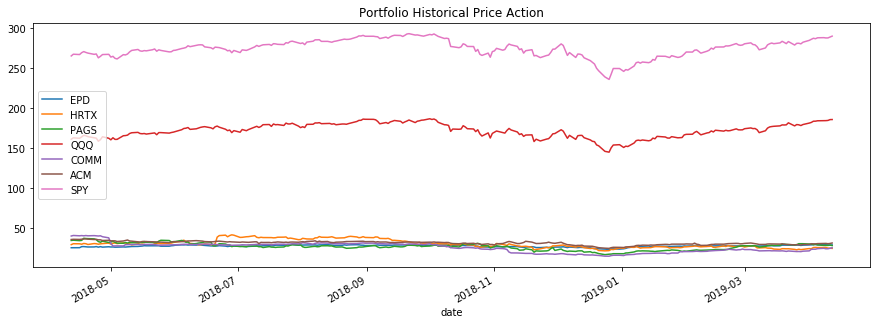

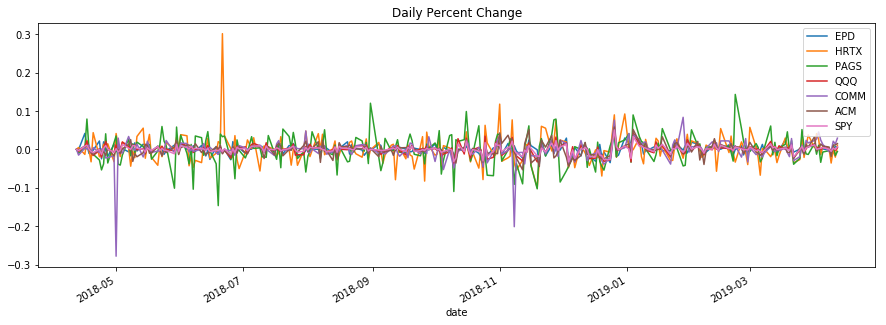

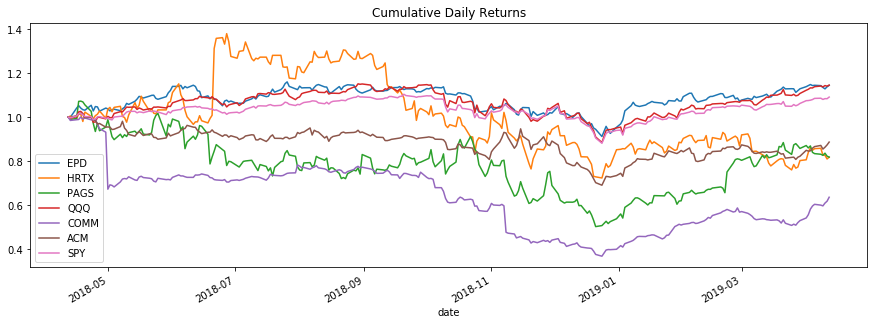

In [25]:
# Plot price action
for sym, data in port.items():
    data['open'].plot(figsize=(15,5), label=sym,legend=True)
plt.title('Portfolio Historical Price Action')
plt.show()

# Plot daily pct change
for sym, data in port_rets.items():
    data['pct change'].plot(figsize=(15,5), label=sym,legend=True)
plt.title('Daily Percent Change')
plt.show()

# Plot cumulative returns
for sym, data in port_rets.items():
    data['cumulative daily'].plot(figsize=(15,5), label=sym,legend=True)
    x = data['cumulative daily']
plt.title('Cumulative Daily Returns')
plt.show()

# Statistical Measurements

In [26]:
# time_of_price={open, high, low, close, adjusted close, volume}
def get_var(ticker, param='adjusted close'):
    return np.var(port[ticker][param]), np.std(port[ticker][param])

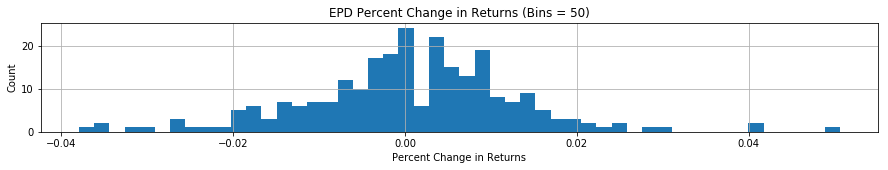

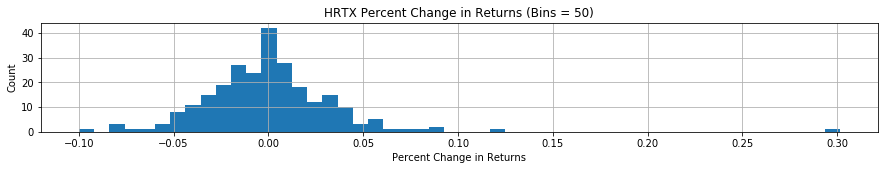

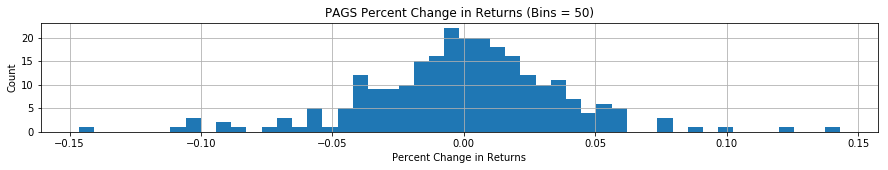

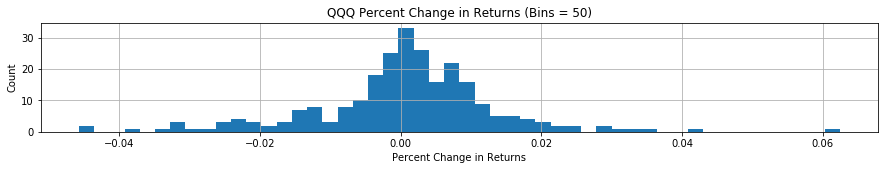

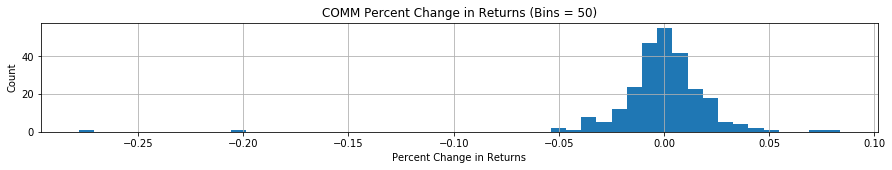

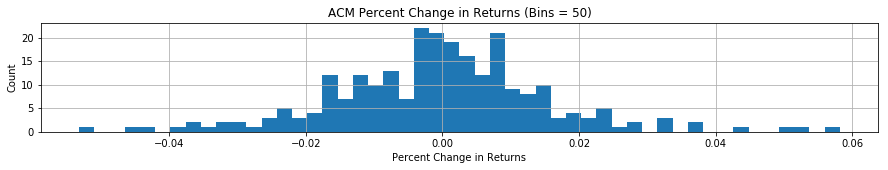

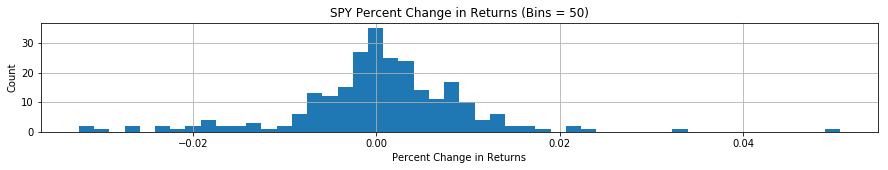

In [27]:
bins = 50
for sym, data in port_rets.items():
    port_rets[sym]['pct change'].hist(bins=bins, figsize=(15,2))
    plt.title(f'{sym} Percent Change in Returns (Bins = {bins})')
    plt.xlabel('Percent Change in Returns')
    plt.ylabel('Count')
    plt.show()

In [28]:
# Plot the volatility of an asset in the portfolio.
# show_price: if True, also plots price data of the stock.
# show_benchmark: if True, also plots volatility of S&P 500.
def plot_port_vol(ticker, min_periods=25, show_price=False, show_bench=False):
    
    global price, bench_vol
    price= None
    bench_vol= None

    # Get the asset volatility and optionally the S&P volatility and price data of the asset.    
    vol = port_rets[ticker]['pct change'].rolling(min_periods).std()*np.sqrt(min_periods)
    if show_bench:
        start = str(port_rets[ticker].index[0])[:-9]
        end = str(port_rets[ticker].index[-1])[:-9]
        bench_data = port['SPY']
        bench_rets = port_rets['SPY']
        bench_vol = bench_rets['pct change'].rolling(min_periods).std()*np.sqrt(min_periods)
    if show_price:
        price = port[ticker]['close']
    
    fig, ax1 = plt.subplots(figsize=(12,3))
    
    vol_color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Percent')
    ax1.plot(vol, color=vol_color, label=ticker)
    ax1.legend(loc=1)
    
    if show_bench:
        bench_color='tab:orange'
        ax1.plot(bench_vol, color=bench_color, label='S&P')
        ax1.legend(loc=1)
    if show_price:
        ax2 = ax1.twinx() # second axes with same x-axis
        price_color = 'tab:blue'
        ax2.set_ylabel(f'{ticker} Price')
        ax2.plot(price, color=price_color, label=f'{ticker} price')
        ax2.tick_params(axis='y', labelcolor=price_color)
        ax2.legend(loc=2)
    vol.dropna()
    asset_mean = vol.mean()
    asset_std_dev = vol.std()
    asset_std_err = vol.sem()
    
    bench_mean = bench_vol.mean()
    bench_std_dev = bench_vol.std()
    bench_std_err = bench_vol.sem()
    
    fig.tight_layout()
    plt.title(f'{ticker} vs. S&P: Volatility ({min_periods}-Day Rolling Period)')
    plt.show()
        
    vol_stats = pd.DataFrame(index=['mean', 'std dev', 'std err'])
    vol_stats[ticker] = pd.Series((asset_mean, asset_std_dev, asset_std_err), index=vol_stats.index)
    vol_stats['S&P 500'] = pd.Series((bench_mean, bench_std_dev, bench_std_err), index=vol_stats.index)
    
    agree=False
    if asset_mean <= bench_mean and asset_mean + asset_std_err >= bench_mean:
        agree = True
    elif asset_mean >= bench_mean and asset_mean - asset_std_err <= bench_mean:
        agree=True
    
    print(vol_stats) 
    print(f'S&P and {ticker} agree within std error: {agree}')

In [29]:
start = str(list(port_rets.values())[0].index[0])[:-9]
end = str(list(port_rets.values())[0].index[-1])[:-9]

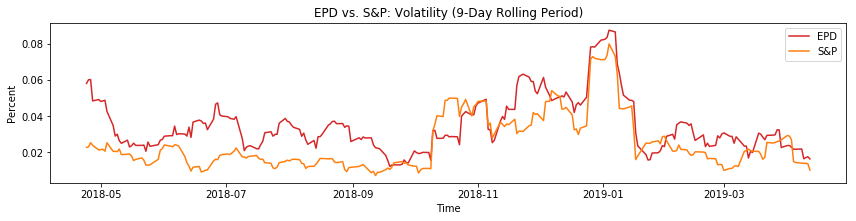

              EPD   S&P 500
mean     0.034346  0.024703
std dev  0.014634  0.014822
std err  0.000935  0.000947
S&P and EPD agree within std error: False


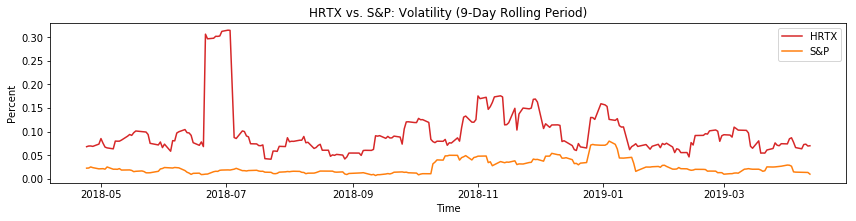

             HRTX   S&P 500
mean     0.097293  0.024703
std dev  0.050173  0.014822
std err  0.003205  0.000947
S&P and HRTX agree within std error: False


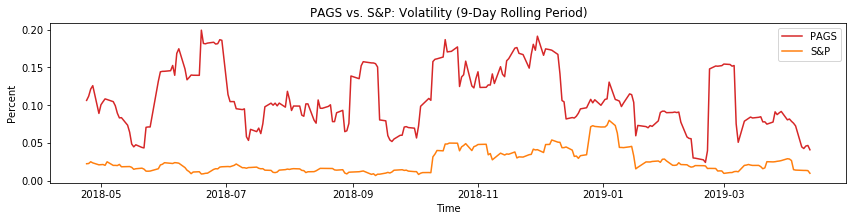

             PAGS   S&P 500
mean     0.108286  0.024703
std dev  0.040358  0.014822
std err  0.002578  0.000947
S&P and PAGS agree within std error: False


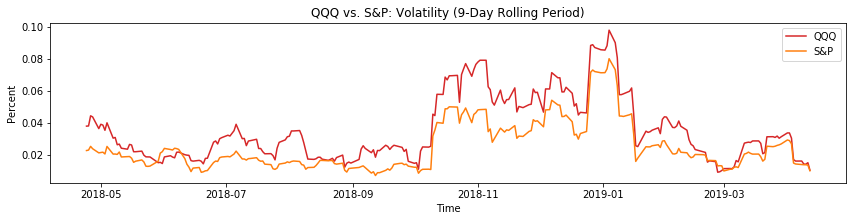

              QQQ   S&P 500
mean     0.035325  0.024703
std dev  0.019994  0.014822
std err  0.001277  0.000947
S&P and QQQ agree within std error: False


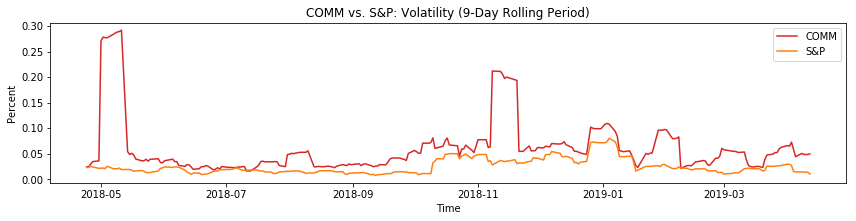

             COMM   S&P 500
mean     0.061199  0.024703
std dev  0.056214  0.014822
std err  0.003591  0.000947
S&P and COMM agree within std error: False


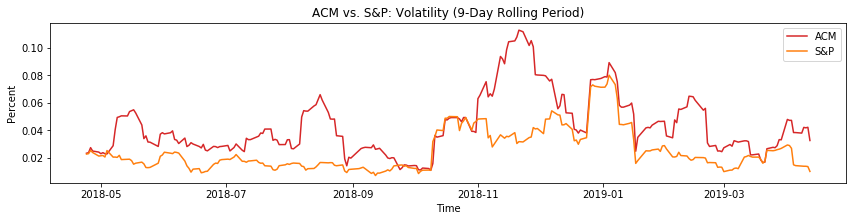

              ACM   S&P 500
mean     0.042860  0.024703
std dev  0.021540  0.014822
std err  0.001376  0.000947
S&P and ACM agree within std error: False


In [30]:
for sym, data in port.items():
    if sym is not 'SPY':
        plot_port_vol(sym, min_periods=9, show_bench=True)
        plt.show()

In [47]:
def plot_linreg(asset_1, asset_2, xlabel=None, ylabel=None, visible=True):
    params = stats.linregress(asset_1, asset_2)
    m = params.slope
    b = params.intercept
    x = np.linspace(np.min(asset_1), np.max(asset_1), 500)
    y = m*x + b
    
    if visible:
        plt.scatter(asset_1, asset_2)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(x, y)
        plt.show()
    
    return '%.3f'%(params.rvalue**2), '%.3f'%(params.pvalue), '%.3f'%(params.stderr)

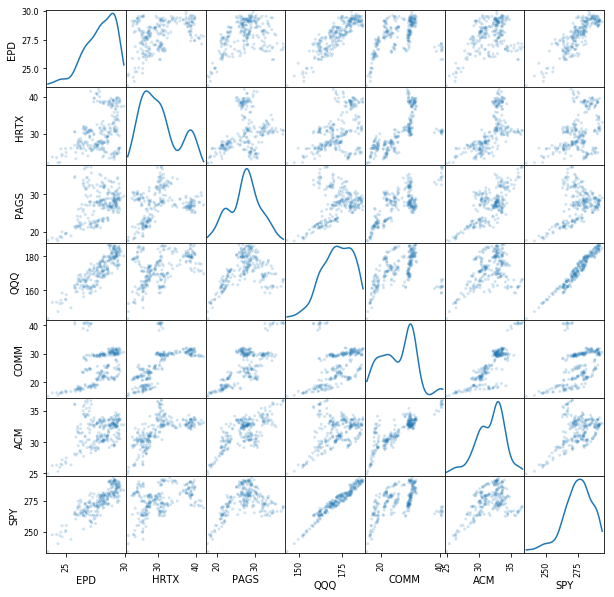

In [48]:
# Plot scatter matrix of portfolio.
close = pd.DataFrame()
for s, d in port.items():
    close[s] = port[s]['close']
pd.plotting.scatter_matrix(close, alpha=0.2,figsize=(10,10), diagonal='kde');

# Plot all linear regressions of the stocks within the portfolio.
hash_combos = []
sym_combos = []

regress_stats = pd.DataFrame(columns=['R squared', 'p value', 'std err'])

#rsq, pval, std

for sym, data in port.items():
    for s, d in port.items():       
        if sym is not s and (hash(sym+s) and hash(s+sym) not in hash_combos):
            rsq,pval,std = plot_linreg(port[sym]['close'], port[s]['close'], visible=False)
            h = hash(sym+s)
            hash_combos.append(h)
            values =pd.Series([float(rsq), float(std), float(pval)], 
                              index=regress_stats.columns).rename(f'{sym}/{s}')
            regress_stats = regress_stats.append(values)

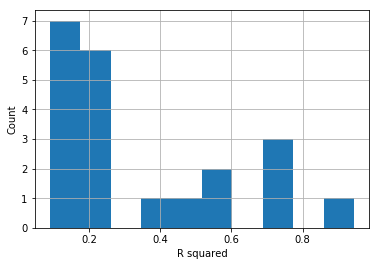

In [49]:
regress_stats['R squared'].hist();
plt.xlabel('R squared');
plt.ylabel('Count');

## Adjusted for Skewness and Kurtosis Sharpe Ratio (ASKSR)

This is a gross oversimplification of the problem that arises with using the standard mean-variance-based Sharpe Ratio. When using the Sharpe Ratio to determine the "risk-reward" value of owning an asset or portfolio of assets, it is assumed that the return data is normally distributed. However, this is almost never the case, so the value of the Sharpe Ratio can be misleading. To account for this, Zakamouline and Koekebakker (2008) authored an article deriving a parametric form of a special-case form of the generalized Sharpe Ratio that accounts for higher-order moments of distribution than just mean and variance. That is, the returns are not assumed to be normally disributed, so the ASKSR accounts for skewness (3rd moment) and kurtossis (4th moment) of the returns distribution of an asset. To read more into the "nitty-gritty," click on the link below.

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1028715&download=yes

The authors chose to use the normal inverse Gaussian distribution (NIGD) because:
1. NIGD has an explicit expression for the probability density function
2. Distributions of risky asset returns can be often fitted extremely well by the NIGD
3. For the NIGD, there are explicit formulas for finding the parameters of the distribution via the values of the first four moments of the distribution.

$\eta$ and $\delta$ are ordinary paramters of location and scale whereas $\alpha$ and $\beta$ determine the shape of the density. In particular, $\beta$ determines the degree of skewwness.

For symmetrical densities, $\beta = 0$. The conditions for a viable NIG density are $\delta > 0$, $\alpha > 0$, and $\frac{\vert \beta \vert}{\alpha} < 1$. Note that to get meaningful parameters of the NIGD, the following conditions must be satisfied:

\begin{align}
K > 3 + \frac{5}{3}S^2
\end{align}

* Mean: $\mu = \eta + \delta\frac{\beta}{\varphi}$

* Variance: $\sigma^2 = \delta\frac{\alpha^2}{\varphi^3}$

* Skew: $S = 3\frac{\beta}{\alpha \sqrt{\delta\varphi}}$

* Kurtosis: $K = 3 + \frac{3}{\delta\varphi}\left( 1 + 4\left(\frac{\beta}{\alpha} \right)^2 \right)$

\begin{align}
ASKSR &= \sqrt{2\left(\lambda a^*(\eta - r) -\delta\left (\varphi - \sqrt{\alpha^2 - (\beta - \lambda a^*)^2}\right)\right)} \\\\
\end{align}

\begin{align}
a^* &= \frac{1}{\lambda}\left(\beta + \frac{\alpha(\eta - r)}{\sqrt{\delta^2 + (\eta - r)^2}} \right) \\\\
\varphi &= \sqrt{\alpha^2 - \beta^2} \\\\
\alpha &= \frac{3\sqrt{a}}{\sigma^2 b} \\\\
\beta &= \frac{3S}{\sigma b} \\\\
\eta &= \mu - \frac{3S\sigma}{a} \\\\
\delta &= 3\sigma\frac{\sqrt{b}}{a} \\\\
a &= 3K - 4S^2 - 9 \\\\
b &= 3K - 5S^2 - 9 \\
\end{align}

Use average of long-term treasury rate for the observed time period:

In [103]:
def asksr():
    
    sharpes = pd.DataFrame(
        columns=['ASKSR', 
                 'SR', 
                 'Delta > 0', 
                 'Alpha > 0', 
                 'Beta/alpha < 1',
                 'Kurtosis/Skewness'])
    r = q.get('USTREASURY/REALLONGTERM', 
          start_date=start, 
              end_date=end).pct_change().dropna().mean()[0]
    
    sharp_dict = {}
    
    for t, d in port_rets.items():
        rets = d['pct change']
        mean = rets.mean()
        var = rets.var()
        skew = rets.skew()
        kurt = rets.kurtosis()
        
        a = 3*kurt - 4*(skew**2)-9
        b = 3*kurt - 5*(skew**2)-9
        alpha = (3*c.sqrt(a))/(var*b)
        beta = (3*skew)/(c.sqrt(var)*b)
        eta = mean - (3*skew*c.sqrt(var))/(a)
        sigma = 3*c.sqrt(var)*(c.sqrt(b)/a)
        phi = c.sqrt(alpha**2 - beta**2)
        delta = (mean - eta)*(phi/beta)
        a_star = beta + (alpha*(eta - r))/(c.sqrt(
            delta**2 + (eta - r)**2))
        
        ASKSR = c.sqrt(2*(a_star*(eta - r) - 
                          delta*(phi - c.sqrt(
                              alpha**2 - (beta - a_star)**2))))
        ASKSR_mag = ASKSR.real**2 + ASKSR.imag**2
        SR = (mean - r)/(np.sqrt(var) - r)
        row = pd.Series(['%.3f'%(ASKSR_mag), 
                        '%.3f'%(SR), 
                        str(delta.real > 0),
                        str(alpha.real > 0), 
                        str((np.abs(beta)/alpha) < 1), 
                        str(kurt > (5/3)*(skew**2) + 3)], 
                       index=sharpes.columns).rename(t)
        sharpes = sharpes.append(row)
    return sharpes

In [106]:
asksr()

,ASKSR,SR,Delta > 0,Alpha > 0,Beta/alpha < 1,Kurtosis/Skewness
EPD,0.008,-0.014,False,False,True,False
HRTX,0.001,-0.027,True,True,True,True
PAGS,0.183,-0.024,False,False,True,False
QQQ,0.000,-0.012,True,True,True,True
COMM,0.077,-0.078,True,True,True,True
ACM,0.008,-0.074,False,False,True,False
SPY,0.002,-0.044,True,True,True,True


# Under Construction

In [105]:
def sharpe_ratio(asset):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

running_sharpe = [sharpe_ratio(rets[i-10:i], 
                               r[i-10:i]) for i in range (10, len(rets))]
_, ax1 = plt.subplots()
ax1.plot(range(10, len(rets)-20), running_sharpe[:-20]);
ticks = ax1.get_xticks()
ax1.set_xticklabels(rets.index)
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio');

NameError: name 'rets' is not defined

## Efficiency Ratio

In [ ]:
np.var(mean-r)

In [ ]:
def eff_rat(symbol, period=7):
    close_data = port[symbol]['close']
    close
    
    return pd.DataFrame()

In [ ]:
close_data = port['EPD']['close']

abs_change = close_data.diff().resample('7D').sum()
#summed_data = close_data.resample('7D')